## 3.2 线性回归网络的从零开始实现

引入必要的包

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

### 3.2.1 生成数据集

根据一个带有噪声的线性模型构造一个人造数据集

In [2]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b噪声"""
    # 生成正态分布的张量
    X = torch.normal(0, 1, (num_examples, len(w)))
    # 执行y=Xw+b运算，其中matmul是矩阵乘法
    y = torch.matmul(X, w) + b
    # 添加噪音
    y += torch.normal(0, 0.01, y.shape)
    # -1表示自动计算行数，使得其转化为一个2D的向量
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

注意，`features`中的每一行都包含一个二维数据样本， `labels`中的每一行都包含一维标签值（一个标量）。

也就是特征和标签。

In [3]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-0.0606, -1.6594]) 
label: tensor([9.7306])


展示**第二个特征**`features[:, 1]`和`labels`的散点图，可以直观观察到两者之间的线性关系。

注意注意：这里仅仅展示了一个特征维度上的标签

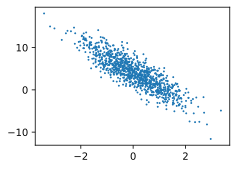

In [4]:
d2l.set_figsize()
# 实际上，下面的(1)括号加不加没有区别
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

### 3.2.2 读取数据集

在下面的代码中，我们定义一个`data_iter`函数， 该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量。 每个小批量包含一组特征和标签。

在这里使用到了`batch_size`的概念哦

需要注意的是，这里带有`yield`的函数是一个生成器，当函数返回某个值时候，会停留在某个位置，下次迭代就再从这个位置开始

简单而言，就是`return`会导致函数结束运行，而`yield`不会

In [5]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    # 对其进行分块处理
    indices = list(range(num_examples))
    # 打乱样本
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        # 每个批量取其对应的样本
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

读取一个小批量样本并打印

In [6]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-1.0611, -0.6608],
        [-0.7273, -1.2552],
        [-0.7152, -0.7416],
        [-0.1996,  0.3303],
        [ 1.4728,  0.5984],
        [-1.3580,  1.9237],
        [-0.4181, -0.0346],
        [ 0.4710,  0.6784],
        [ 0.3287,  0.9022],
        [-0.5366,  0.1558]]) 
 tensor([[ 4.3323],
        [ 7.0096],
        [ 5.2966],
        [ 2.6880],
        [ 5.1169],
        [-5.0529],
        [ 3.4950],
        [ 2.8348],
        [ 1.7872],
        [ 2.5969]])


一样的，迭代太慢了，所以用这种内置的迭代器

### 3.2.3初始化模型参数

通过正态分布初始化$\bm{w}$，偏置默认为0，在后面使用[2.5](2-5.ipynb)节中的自动微分来计算梯度

In [7]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

### 3.2.4 定义模型

In [8]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

### 3.2.5 定义损失函数

In [9]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### 3.2.6 定义优化算法

In [10]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        # 对每个参数进行梯度下降，其中的lr是学习率
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 3.2.7 训练

**非常重要！！！**

概括而言，将执行以下操作：

- 初始化训练参数
- 重复以下训练，直到完成
    - 计算梯度$\bm{g}\leftarrow\partial_{(\bm{w},b)}\frac{1}{|\mathcal{B}|}\sum_{i\in\mathcal{B}}l(\bm{x}^{(i)},y^{(i)},\bm{w},b)$
    - 更新参数$(\bm{w},b)\leftarrow(\bm{w},b)-\eta\bm{g}$

In [11]:
lr = 0.03  # 学习率
num_epochs = 3  # 迭代次数
net = linreg  # 网络
loss = squared_loss  # 损失函数

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # 计算损失
        # 将l转化为标量进行反向传播
        l.sum().backward()
        # 使用小批量随机梯度下降迭代模型参数
        sgd([w, b], lr, batch_size)
    # 评价部分，不需要计算梯度，不参与训练
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.044425
epoch 2, loss 0.000169
epoch 3, loss 0.000049


In [12]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0002, -0.0003], grad_fn=<SubBackward0>)
b的估计误差: tensor([-2.1935e-05], grad_fn=<RsubBackward1>)


### 3.2.8 小结

- 我们学习了深度网络是如何实现和优化的。在这一过程中只使用张量和自动微分，不需要定义层或复杂的优化器。
- 这一节只触及到了表面知识。在下面的部分中，我们将基于刚刚介绍的概念描述其他模型，并学习如何更简洁地实现其他模型。

### 3.2.9 练习

1. 如果我们将权重初始化为0，会发生什么。算法依然有效吗？

    答. 依然是有效的，实际上梯度能否有效传递仅仅与模型是否陷入了局部最优有关，只要它能在那个点求导并且导数不为0，就仍然可以进行有效的反向传播。ControlNet中的Zero-Convolution正是做了这个事情